#### Dataset: 
- Train Dataset[MEBOW]: http://images.cocodataset.org/zips/train2017.zip
- Validation Dataset [MEBOW]: http://images.cocodataset.org/zips/val2017.zip
- Benchmark dataset [TUD Multiview Pedestrians]: https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/people-detection-pose-estimation-and-tracking/monocular-3d-pose-estimation-and-tracking-by-detection/

#### Import Library

In [1]:
import os
import json
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

Matplotlib is building the font cache; this may take a moment.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Enable CUDA debug information
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#### Visualization Step

The following codes takes in samples and annotations. Then for each annotated person, the bounding box is drawn and the body annotation is displayed.

In [3]:
def visualize_annotations(img_dir, annotations_file, num_images=10, grid_size=(2, 5)):
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)
    
    img_names = list(annotations.keys())[:num_images]
    
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 10))
    axes = axes.flatten()

    for idx, img_name in enumerate(img_names):
        img_path = os.path.join(img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(image)

        for annotation in annotations[img_name]:
            bbox = annotation["bbox"]
            label = annotation["label"]
            
            # Convert bbox from [x, y, width, height] to [x_min, y_min, x_max, y_max]
            x_min, y_min = bbox[0], bbox[1]
            x_max, y_max = x_min + bbox[2], y_min + bbox[3]
            
            # Draw bounding box
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)
            draw.text((x_min, y_min), f"Label: {label}", fill="white")
        
        axes[idx].imshow(image)
        axes[idx].set_title(f"Orientation: {annotation['label']}")
        axes[idx].axis('off')

    # Remove empty subplots
    for i in range(len(img_names), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

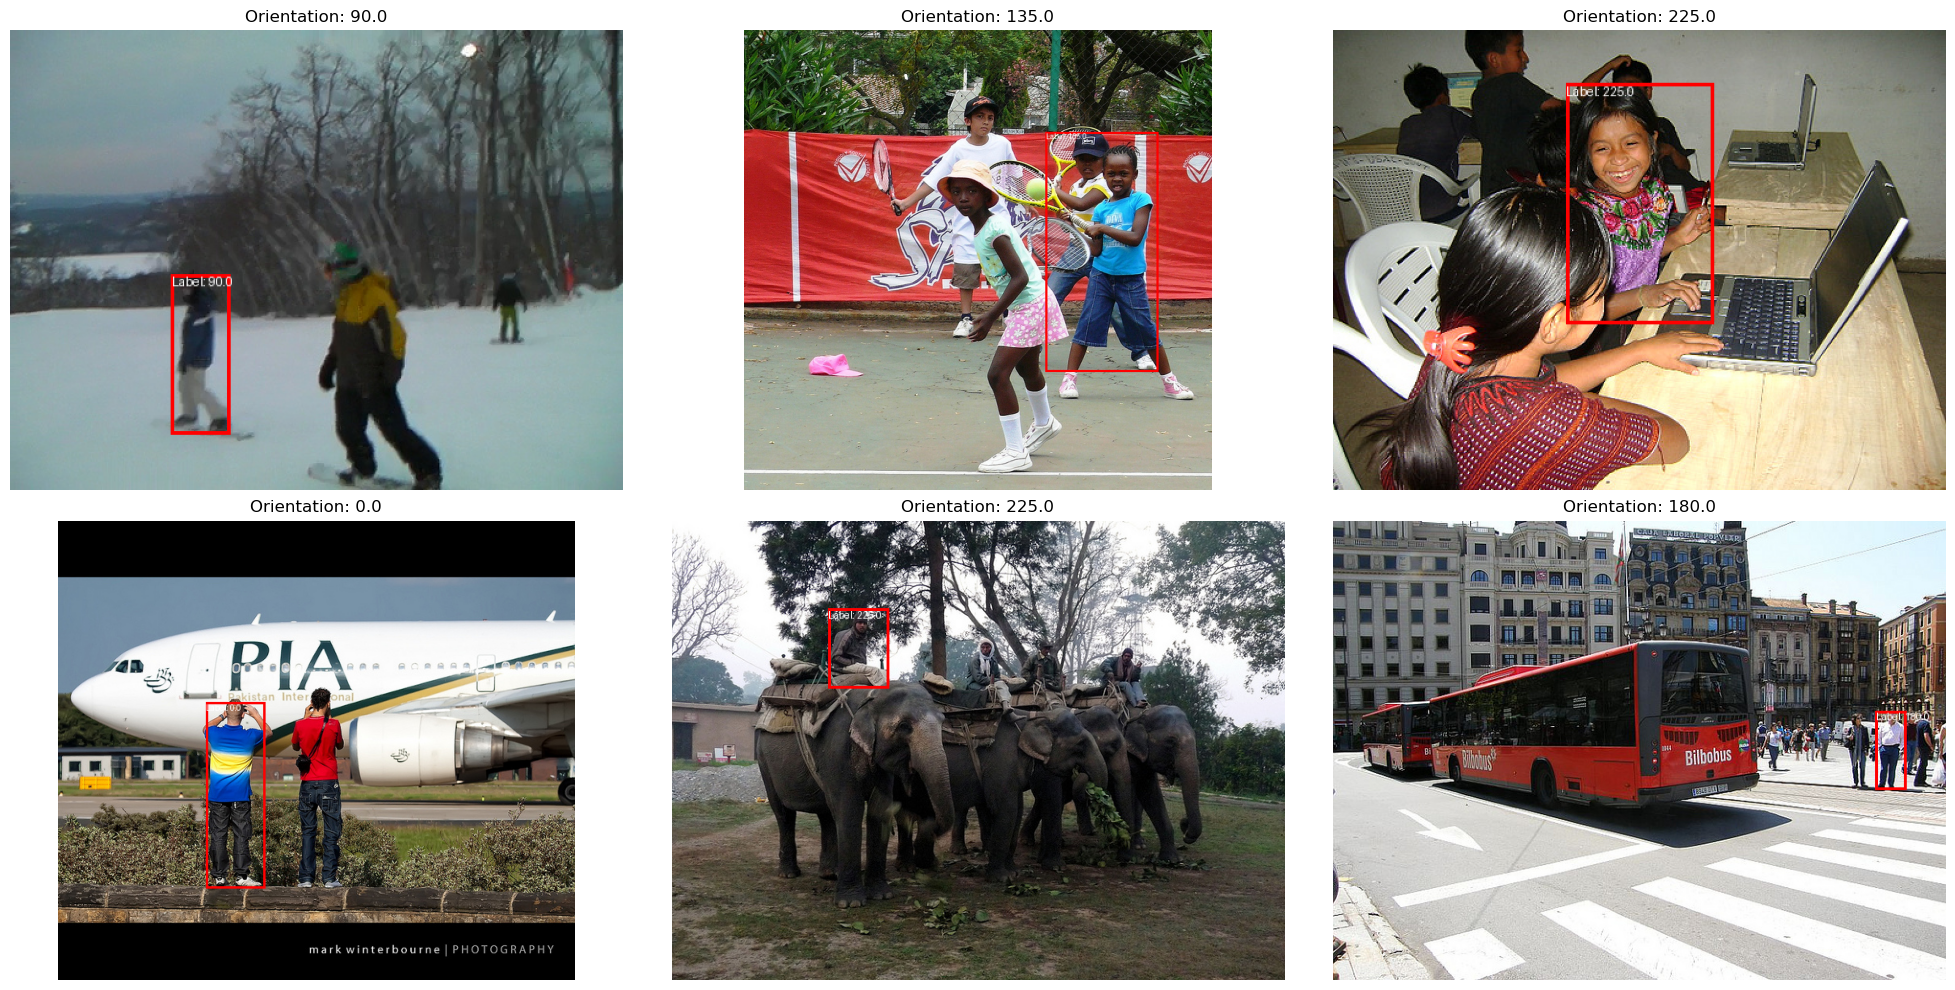

In [ ]:
img_dir = 'datasets/coco2017_8orienation_train/'
annotations_file = 'datasets/train_coco2017_annotation_new.json'

visualize_annotations(img_dir, annotations_file, num_images=6, grid_size=(2, 3))

#### Modelling Step

The following code is dataloader which takes the image from the folder and extracts person image using bounding box, then it maps the annotation. It helps in efficient mapping.

In [16]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None):
        self.img_dir = img_dir
        with open(annotations_file, 'r') as f:
            self.annotations = json.load(f)
        self.transform = transform
        self.img_names = list(self.annotations.keys())
        self.class_mapping = {0: 0, 45: 1, 90: 2, 135: 3, 180: 4, 225: 5, 270: 6, 315: 7}

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        annotations = self.annotations[img_name]

        cropped_images = []
        labels = []

        for annotation in annotations[:1]:
            bbox = annotation["bbox"]
            degree = annotation["label"]

            # Convert bbox from [x, y, width, height] to [x_min, y_min, x_max, y_max]
            x_min, y_min = bbox[0], bbox[1]
            x_max, y_max = x_min + bbox[2], y_min + bbox[3]

            # Crop the image based on the bounding box
            cropped_image = image.crop((x_min, y_min, x_max, y_max))

            if self.transform:
                cropped_image = self.transform(cropped_image)

            cropped_images.append(cropped_image)
            labels.append(self.class_mapping[degree])

        return cropped_images[0], torch.tensor(labels, dtype=torch.long)[0]

#### Pre-processing Step
Generates the dataloaders, resizes the images, convert to tensors and then normalizes the image pixels.

In [ ]:
def get_data_loaders(train_img_dir, 
                     train_annotations_file, 
                     val_img_dir, 
                     val_annotations_file, 
                     batch_size=8):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = CustomDataset(img_dir=train_img_dir, annotations_file=train_annotations_file, transform=transform)
    val_dataset = CustomDataset(img_dir=val_img_dir, annotations_file=val_annotations_file, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return train_loader, val_loader

The given code initialies the ResNet50 Architecture and pretrained weights. The output layer from ResNet50 is connected with Fully connected layer of 8 neurons for each classes.

In [17]:
class PedestrianDetectionModel(nn.Module):
    def __init__(self, num_classes=8):
        super(PedestrianDetectionModel, self).__init__()
        self.model = models.resnet50(weights=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.model(x)

The given code shows the function to train the model

In [ ]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        _ , predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = correct / total
    
    return epoch_loss, accuracy

In [9]:
def validate(model, val_loader, criterion):
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = correct / total
    
    return val_loss, val_accuracy

In [10]:
def test(model, data_loader, criterion):
    model.eval()
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return true_labels, predicted_labels

In [11]:
# Hyperparameters Values
batch_size = 64
num_epochs = 15
learning_rate = 0.001

train_img_dir = "datasets/coco2017_8orienation_train/"
val_img_dir = "datasets/coco2017_8orientation_val/"

train_annotations_file = "datasets/train_coco2017_annotation_new.json"
val_annotations_file = "datasets/val_coco2017_annotation_new.json"

In [12]:
train_loader, val_loader = get_data_loaders(train_img_dir, 
                                            train_annotations_file, 
                                            val_img_dir, 
                                            val_annotations_file, 
                                            batch_size)

In [ ]:
model = PedestrianDetectionModel(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

trainining_info = {"accuracy": [], "loss": []}
validation_info = {"accuracy": [], "loss": []}

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy = validate(model, val_loader, criterion)
    
    trainining_info["accuracy"].append(train_accuracy)
    trainining_info["loss"].append(train_loss)
    validation_info["accuracy"].append(val_accuracy)
    validation_info["loss"].append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]
100%|██████████| 173/173 [03:31<00:00,  1.22s/it]


Epoch [1/15], Train Loss: 1.2929, Train Accuracy: 0.5287815507535863, Val Loss: 1.4984, Val Accuracy: 0.4779


100%|██████████| 173/173 [01:44<00:00,  1.66it/s]


Epoch [2/15], Train Loss: 0.9361, Train Accuracy: 0.6596150354094789, Val Loss: 1.1919, Val Accuracy: 0.5691


100%|██████████| 173/173 [01:44<00:00,  1.65it/s]


Epoch [3/15], Train Loss: 0.7737, Train Accuracy: 0.7205374977301616, Val Loss: 1.1828, Val Accuracy: 0.5856


100%|██████████| 173/173 [01:44<00:00,  1.65it/s]


Epoch [4/15], Train Loss: 0.6771, Train Accuracy: 0.7554022153622663, Val Loss: 0.8792, Val Accuracy: 0.7099


100%|██████████| 173/173 [01:44<00:00,  1.65it/s]


Epoch [5/15], Train Loss: 0.5478, Train Accuracy: 0.8012529507899038, Val Loss: 0.9759, Val Accuracy: 0.6657


100%|██████████| 173/173 [01:44<00:00,  1.65it/s]


Epoch [6/15], Train Loss: 0.4760, Train Accuracy: 0.832304339930997, Val Loss: 0.9347, Val Accuracy: 0.6961


100%|██████████| 173/173 [01:44<00:00,  1.65it/s]


Epoch [7/15], Train Loss: 0.4313, Train Accuracy: 0.8471036862175413, Val Loss: 0.8406, Val Accuracy: 0.7459


100%|██████████| 173/173 [01:44<00:00,  1.65it/s]


Epoch [8/15], Train Loss: 0.3409, Train Accuracy: 0.8794261848556383, Val Loss: 0.8174, Val Accuracy: 0.7541


100%|██████████| 173/173 [01:44<00:00,  1.65it/s]


Epoch [9/15], Train Loss: 0.2684, Train Accuracy: 0.9082985291447249, Val Loss: 0.8762, Val Accuracy: 0.7320


100%|██████████| 173/173 [01:44<00:00,  1.65it/s]


Epoch [10/15], Train Loss: 0.2637, Train Accuracy: 0.9074813873252224, Val Loss: 1.1369, Val Accuracy: 0.6934


100%|██████████| 173/173 [01:44<00:00,  1.65it/s]


Epoch [11/15], Train Loss: 0.2443, Train Accuracy: 0.9139277283457418, Val Loss: 0.9397, Val Accuracy: 0.6934


100%|██████████| 173/173 [01:44<00:00,  1.65it/s]


Epoch [12/15], Train Loss: 0.1648, Train Accuracy: 0.9402578536408208, Val Loss: 1.4778, Val Accuracy: 0.7044


100%|██████████| 173/173 [01:44<00:00,  1.65it/s]


Epoch [13/15], Train Loss: 0.1535, Train Accuracy: 0.9461594334483385, Val Loss: 0.9992, Val Accuracy: 0.7293


100%|██████████| 173/173 [01:44<00:00,  1.65it/s]


Epoch [14/15], Train Loss: 0.2550, Train Accuracy: 0.9107499546032323, Val Loss: 0.8557, Val Accuracy: 0.7541


100%|██████████| 173/173 [01:44<00:00,  1.65it/s]


Epoch [15/15], Train Loss: 0.1961, Train Accuracy: 0.9322680225167969, Val Loss: 1.0154, Val Accuracy: 0.7541


In [ ]:
# Predict the test set using the trained model
y_true, y_pred = test(model, val_loader, criterion)

In [ ]:
# Using the ground label and predicted label, the classification report is created
report = classification_report(y_true, y_pred, target_names=['0', '45', '90', '135', '180', '225', '270', '315'])
print(report)

              precision    recall  f1-score   support

           0       0.92      0.56      0.70        39
          45       0.86      0.50      0.63        24
          90       0.67      0.80      0.73        25
         135       0.71      0.88      0.78        58
         180       0.88      0.86      0.87        85
         225       0.86      0.81      0.83        78
         270       0.41      0.87      0.56        23
         315       0.71      0.40      0.51        30

    accuracy                           0.75       362
   macro avg       0.75      0.71      0.70       362
weighted avg       0.79      0.75      0.75       362

